# Asteroid Class Prediction Leveraging Parallelization Techniques 

<div style="text-align: right">  
<strong>Uday Kiran Dasari</strong>
</div>
<br/>
<center>
<img src="Asteroid.jpg" width=700 />
</center>
<br/>

**Link to Dataset used**: [**Asteroid Dataset**](https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset/data)

### Dataset Description

- **SPK-ID:** Object primary SPK-ID
- **Object ID:** Object internal database ID
- **Object fullname:** Object full name/designation
- **pdes:** Object primary designation
- **name:** Object IAU name
- **NEO:** Near-Earth Object (NEO) flag
- **PHA:** Potentially Hazardous Asteroid (PHA) flag
- **H:** Absolute magnitude parameter
- **Diameter:** Object diameter (from equivalent sphere) km Unit
- **Albedo:** Geometric albedo
- **Diameter_sigma:** 1-sigma uncertainty in object diameter km Unit
- **Orbit_id:** Orbit solution ID
- **Epoch:** Epoch of osculation in modified Julian day form
- **Equinox:** Equinox of reference frame
- **e:** Eccentricity
- **a:** Semi-major axis au Unit
- **q:** Perihelion distance au Unit
- **i:** Inclination; angle with respect to x-y ecliptic plane
- **tp:** Time of perihelion passage TDB Unit
- **moid_ld:** Earth Minimum Orbit Intersection Distance au Unit
-y ecliptic plane

### Necessary Libraries

In [1]:
# Basic imports
import joblib
import numpy as np
import pandas as pd
import time

# Visualization imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Dask-related imports
import dask
import dask.array as da
import dask.dataframe as dd
from dask_ml.impute import SimpleImputer
from dask.distributed import Client, config,performance_report
from dask.diagnostics import ProgressBar
from dask_ml.model_selection import GridSearchCV,train_test_split

# Set the daemon configuration for Dask workers
dask.config.set({'distributed.worker.daemon': False})

import multiprocessing
import torch

# Inline matplotlib setup
%matplotlib inline

In [2]:
num_cpu_cores = torch.get_num_threads()
print("Number of CPU cores:", num_cpu_cores)

Number of CPU cores: 28


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data Preprocessing

#### Loading the dataset

In [4]:
%%time
# Load the dataset with specified data types
#data = dd.read_csv('./dataset.csv', dtype=dtype)
astro_ds = dd.read_csv('./dataset.csv',blocksize=50e6)#50MB Chunks
astro_ds

CPU times: user 44.3 ms, sys: 10.3 ms, total: 54.5 ms
Wall time: 55.3 ms


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
npartitions=9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,string,int64,string,int64,string,float64,string,string,float64,float64,float64,float64,string,float64,int64,float64,string,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Check data types and info
print(astro_ds.dtypes)
astro_ds.head()

id                string[pyarrow]
spkid                       int64
full_name         string[pyarrow]
pdes                        int64
name              string[pyarrow]
prefix                    float64
neo               string[pyarrow]
pha               string[pyarrow]
H                         float64
diameter                  float64
albedo                    float64
diameter_sigma            float64
orbit_id          string[pyarrow]
epoch                     float64
epoch_mjd                   int64
epoch_cal                 float64
equinox           string[pyarrow]
e                         float64
a                         float64
q                         float64
i                         float64
om                        float64
w                         float64
ma                        float64
ad                        float64
n                         float64
tp                        float64
tp_cal                    float64
per                       float64
per_y         

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [6]:
%%time
# Drop columns early in the process
columns_to_drop = ['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id', 'equinox']
astro_ds = astro_ds.drop(columns_to_drop, axis=1)
astro_ds.head()

CPU times: user 490 ms, sys: 116 ms, total: 606 ms
Wall time: 605 ms


,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,2000001,3.40,939.400,0.0900,0.200,2458600.5,58600,20190427.0,0.076009,2.769165,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,2000002,4.20,545.000,0.1010,18.000,2459000.5,59000,20200531.0,0.229972,2.773841,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,2000003,5.33,246.596,0.2140,10.594,2459000.5,59000,20200531.0,0.256936,2.668285,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,2000004,3.00,525.400,0.4228,0.200,2458600.5,58600,20190427.0,0.088721,2.361418,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,2000005,6.90,106.699,0.2740,3.140,2459000.5,59000,20200531.0,0.190913,2.574037,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [7]:
astro_ds.describe().compute()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.234915e+06,16.500000,3.254000,0.069500,0.252000,2.459000e+06,59000.000000,2.020053e+07,0.104812,2.420376,...,1.614700e-07,6.589100e-06,4.876450e-05,7.004150e-05,2.982100e-05,2.720850e-08,3.066100e-09,1.351000e-04,2.138100e-05,0.546550
50%,2.472881e+06,17.400000,4.881000,0.093500,0.470000,2.459000e+06,59000.000000,2.020053e+07,0.169457,2.678653,...,2.988700e-07,1.040400e-05,9.596200e-05,1.303475e-04,6.605900e-05,6.829900e-08,6.743000e-09,3.032000e-04,5.492000e-05,0.583000
75%,3.778898e+06,18.751000,6.201000,0.188000,0.804000,2.459000e+06,59000.000000,2.020053e+07,0.236891,3.041370,...,1.258550e-04,2.289700e-04,1.837200e-03,1.699325e-02,3.425325e-02,2.241700e-04,1.792200e-06,1.034500e-01,1.597000e-01,0.635975
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


In [8]:
astro_ds.isnull().sum().compute()

spkid                  0
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
epoch                  0
epoch_mjd              0
epoch_cal              0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926
sigma_n            19922
sigma_tp           19922
sigma_per          19926
class                  0
rms                    2
dtype: int64

#### Null Value Handling

In [9]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds.drop(['class'], axis=1)
y = astro_ds['class']

In [10]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
imputer = SimpleImputer(strategy='median')

# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [11]:
# Ensure that imputation and other transformations are computed efficiently
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.99 ss
[########################################] | 100% Completed | 1.71 ss


### Feature Importance


- Using the Extra Trees Classifier using `JOBLIB` and `MULTIPROCESSING` libraries

In [12]:
%%time
# Split data into training and test sets (consider doing this before imputation if you want a more rigorous evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle =True ,random_state=42)

# Initialize the ExtraTreesClassifier
# Note: You can adjust n_estimators, max_depth, and other parameters as needed
etc = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# To leverage parallel computation with Dask when performing model fitting
start_time=time.time()
with joblib.parallel_backend('multiprocessing'):
    # Fit the model
    etc.fit(X_train, y_train)
print(f"Time Taken for ETC classifier:{time.time()-start_time:.2f}Seconds")

Time Taken for ETC classifier:12.94Seconds
CPU times: user 3.3 s, sys: 3.29 s, total: 6.59 s
Wall time: 13.7 s


#### Visualizing the feature importances

In [13]:
# Compute and print feature importances
feature_importances = etc.feature_importances_

# Create a dictionary to hold feature names and their importance values
features = X_train.columns
feature_importance_dict = dict(zip(features, feature_importances))

# Print feature importances along with their names
print("Feature importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.5f}")

Feature importances:
spkid: 0.00362
H: 0.03838
diameter: 0.00147
albedo: 0.00202
diameter_sigma: 0.00093
epoch: 0.00212
epoch_mjd: 0.00240
epoch_cal: 0.00262
e: 0.08447
a: 0.09164
q: 0.12006
i: 0.02628
om: 0.00211
w: 0.00271
ma: 0.00284
ad: 0.06170
n: 0.14168
tp: 0.00455
tp_cal: 0.00439
per: 0.09215
per_y: 0.10017
moid: 0.10671
moid_ld: 0.08581
sigma_e: 0.00131
sigma_a: 0.00131
sigma_q: 0.00157
sigma_i: 0.00165
sigma_om: 0.00159
sigma_w: 0.00152
sigma_ma: 0.00161
sigma_ad: 0.00129
sigma_n: 0.00118
sigma_tp: 0.00160
sigma_per: 0.00173
rms: 0.00281


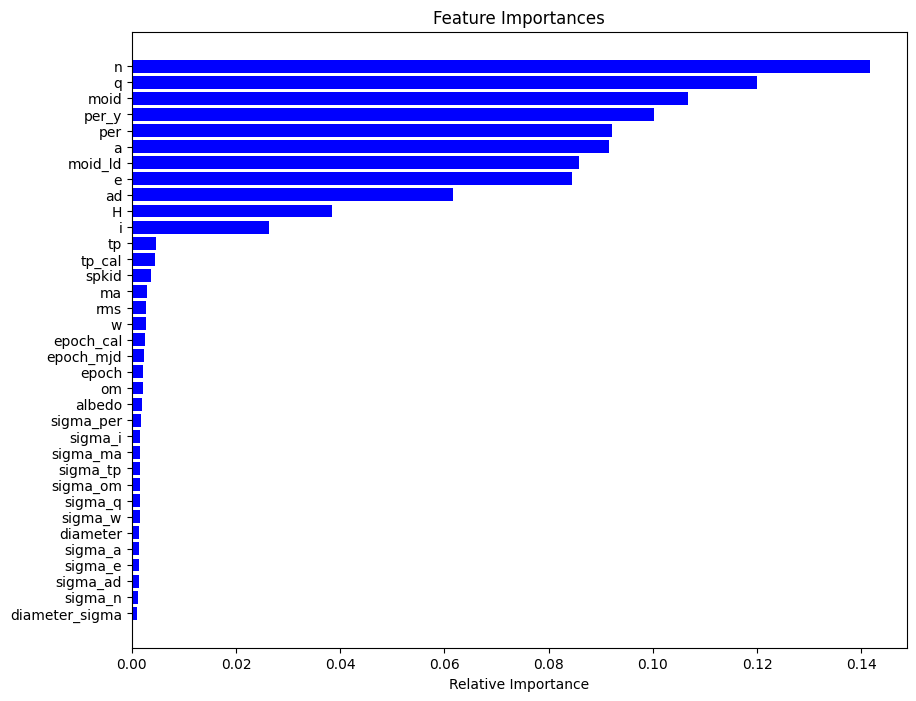

In [14]:
# Visualize the feature importance
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Selection of Importance Features

In [15]:
threshold = np.mean(feature_importances)  # Define your threshold here

# Selecting features with importance greater than the threshold
selected_features = [feature for feature, importance in zip(X_train.columns, feature_importances) if importance > threshold]

print("Selected features:", selected_features)

Selected features: ['H', 'e', 'a', 'q', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld']


In [16]:
# Include 'class' in selected features
selected_features.append('class')

# Filter the original Dask DataFrame to include only selected features
astro_ds_filtered = astro_ds[selected_features]

In [17]:
# Prepare features for imputation (excluding the target 'class')
X = astro_ds_filtered.drop(['class'], axis=1)
y = astro_ds_filtered['class']

In [18]:
# Applying SimpleImputer from Dask-ML to handle missing values in parallel
# Since Dask works with lazy evaluation, use compute() to perform the computation
X_imputed = imputer.fit_transform(X)

In [19]:
with ProgressBar():
    X_imputed = X_imputed.compute()  # This will trigger the actual computation
    y = y.compute()  # Ensure the target variable is also ready for model training

[########################################] | 100% Completed | 1.61 ss
[########################################] | 100% Completed | 1.65 ss


### Test Train Split

In [20]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2,shuffle=True, random_state=42)

In [21]:
type(X_train),type(X_test),type(y_train),type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

#### Scaling and Encoding

In [22]:
# Scaling the data using Dask-ML's StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [24]:
type(X_train_scaled),type(X_test_scaled),type(y_train_encoded),type(y_test_encoded)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [25]:
X_train_scaled.shape,X_test_scaled.shape,y_train_encoded.shape,y_test_encoded.shape

((766819, 10), (191705, 10), (766819,), (191705,))

In [26]:
# If these are pandas DataFrame, convert them to Dask DataFrame
#X_train, y_train, X_test, y_test = dd.from_pandas(X_train), dd.from_pandas(y_train), dd.from_pandas(X_test), dd.from_pandas(y_test)

## Random Forest

#### Parameter Grid

In [27]:
# Set up hyperparameter grid for tuning
# param_grid_rf = {
#      'n_estimators': [50,100],  # number of trees in the forest
#      'max_depth': [10, 20, 30],  # maximum depth of each tree
#      'min_samples_split': [2, 5, 10],
#      'min_samples_leaf': [1, 2, 4]}

param_grid_rf = {
    'n_estimators': [50],# number of trees in the forest
    'max_depth': [10, 20],  # maximum depth of each tree
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

### Running RandomForest on multiple CPUs
- **Using Dask Client and Joblib for parallelization**

In [28]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
def run_grid_search_with_different_cpus(X_train, y_train, X_test, y_test, param_grid, cpu_configs):
    results = {}

    for cpus in cpu_configs:
        print(f"Random Forest for {cpus} CPUs")
        # Close the existing Dask client if it is open
        if 'client' in locals():
            client.close()

        # Calculate the number of workers and threads per worker
        n_workers = cpus // 4
        threads_per_worker = 4
        
        # Initialize a new Dask client with the current configuration
        client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker)

        # Print the Dask dashboard URL
        print(f"Dask Dashboard URL for {cpus} CPUs: {client.dashboard_link}")

        # Set up the RandomForest model with grid search
        rf = RandomForestClassifier(random_state=42)
        grid_search_rf = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')

        # Execute the grid search
        start_time = time.time()
        with ProgressBar(), joblib.parallel_backend('dask'):
            grid_search_rf.fit(X_train, y_train)
        end_time = time.time()
         # Time taken
        time_taken_rf = end_time - start_time
        print(f"Time taken for hyperparameter tuning of RF with {cpus}: {time_taken_rf:.2f} seconds\n")
        # Evaluate the model
        best_rf = grid_search_rf.best_estimator_
        predictions_rf = best_rf.predict(X_test)
        accuracy_rf = accuracy_score(y_test, predictions_rf)
        # Store results        
        results[cpus] = {
            'Time Taken': end_time - start_time,
            'Best Parameters': grid_search_rf.best_params_,
            'Best Score': grid_search_rf.best_score_,
            'Best Estimator': best_rf,
            'Test Accuracy': accuracy_rf,
            'Predictions': predictions_rf
        }

        client.close()

   # Plotting the results
    cpus_list = list(results.keys())
    training_times = [results[cpus]['Time Taken'] for cpus in cpus_list]
    accuracies = [results[cpus]['Test Accuracy'] for cpus in cpus_list]

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, training_times, marker='o', color='b')
    plt.title('Training Time Across Different CPU Configurations for Random Forest')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(cpus_list, accuracies, marker='o', color='r')
    plt.title('Accuracy Across Different CPU Configurations for Random Forest')
    plt.xlabel('Number of CPUs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return results

Random Forest for 4 CPUs
Dask Dashboard URL for 4 CPUs: http://127.0.0.1:8787/status
Time taken for hyperparameter tuning of RF with 4: 408.51 seconds

Random Forest for 8 CPUs
Dask Dashboard URL for 8 CPUs: http://127.0.0.1:8787/status
Time taken for hyperparameter tuning of RF with 8: 292.67 seconds

Random Forest for 16 CPUs
Dask Dashboard URL for 16 CPUs: http://127.0.0.1:8787/status
Time taken for hyperparameter tuning of RF with 16: 225.94 seconds

Random Forest for 20 CPUs
Dask Dashboard URL for 20 CPUs: http://127.0.0.1:8787/status
Time taken for hyperparameter tuning of RF with 20: 212.05 seconds



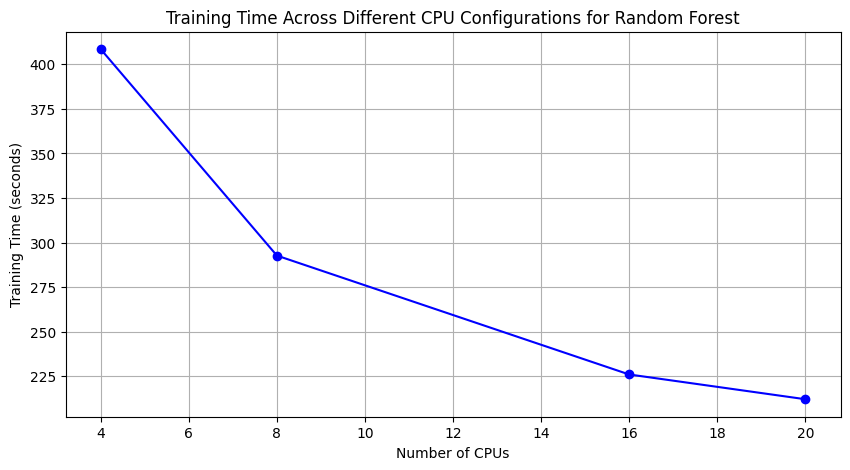

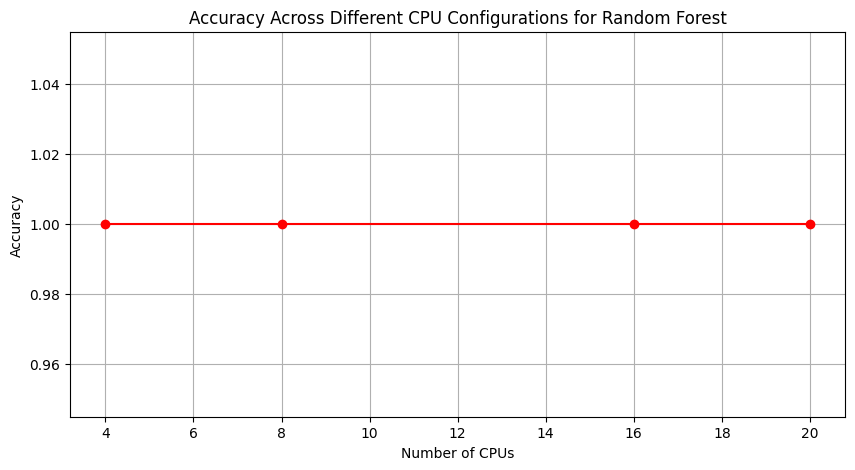

Total time taken for Random Forest on multiple CPUs:1167.3462159633636seconds


In [29]:
start=time.time()
cpu_configs = [4,8,16,20]
results = run_grid_search_with_different_cpus(X_train, y_train, X_test, y_test, param_grid_rf, cpu_configs)
end=time.time()
print(f"Total time taken for Random Forest on multiple CPUs:{end-start}seconds")

### Further Evaluation and Visualization

In [30]:
# Select a specific CPU configuration to analyze
cpu_to_analyze = 16
results_rf=results
# Best model from the results
best_rf = results_rf[cpu_to_analyze]['Best Estimator']
predictions_rf = results_rf[cpu_to_analyze]['Predictions']

In [31]:
# Print best parameters and best score
print("Best parameters found for Random Forest: ", results_rf[cpu_to_analyze]['Best Parameters'])
print("Best accuracy achieved by Random Forest: ", results_rf[cpu_to_analyze]['Best Score'])
print("Accuracy on Test Set by Random Forest: ", results_rf[cpu_to_analyze]['Test Accuracy'])
print("Random Forest Classification Report:\n", classification_report(y_test, predictions_rf))

Best parameters found for Random Forest:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best accuracy achieved by Random Forest:  0.9999608773387201
Accuracy on Test Set by Random Forest:  0.999979134607861
Random Forest Classification Report:
               precision    recall  f1-score   support

         AMO       1.00      1.00      1.00      1745
         APO       1.00      1.00      1.00      2540
         AST       0.91      1.00      0.95        10
         ATE       1.00      1.00      1.00       333
         CEN       1.00      1.00      1.00       108
         HYA       1.00      1.00      1.00         1
         IEO       1.00      1.00      1.00         4
         IMB       1.00      1.00      1.00      4035
         MBA       1.00      1.00      1.00    171100
         MCA       1.00      1.00      1.00      3795
         OMB       1.00      1.00      1.00      5731
         TJN       1.00      1.00      1.00      1619
         TNO 

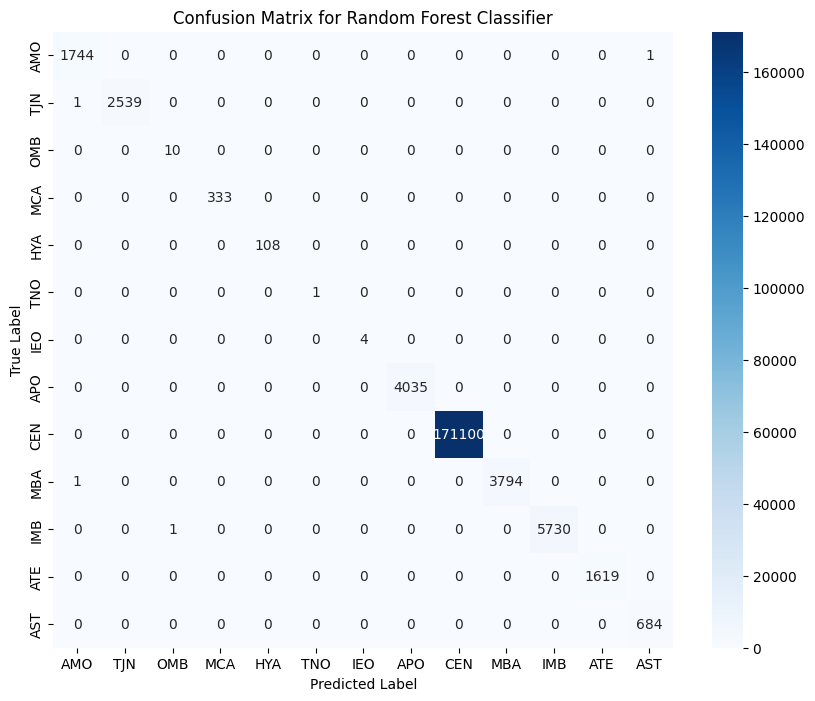

In [32]:
# Confusion Matrix
unique_classes = astro_ds['class'].unique().compute().tolist() 
conf_matrix_rf = confusion_matrix(y_test, predictions_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues', cbar=True,
            xticklabels=unique_classes,
            yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()